<h1 align='center'><font color='orange'>Bike Sharing Demand Prediction</font></h1>
<h3 align='center'><font color='orange'><i>A Machine Learning approach to forecast Bike Rental Demand</i></font></h3>
<h2 align='center'><font color='orange'>Part 3 - Modelling</font></h2>

## <i>To try out the project, [click here...](https://www.google.com/)</i>

#### -> To check out Part 1 (Exploratory Data Analysis), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/Bike_Sharing_EDA_Part1.ipynb)
#### ->To check out Part 2 (Data Preparation), [click here](https://nbviewer.jupyter.org/github/SarthakRana/Bike-Sharing-Demand-Prediction/blob/main/bike_sharing_data_preparation_Part2.ipynb)

<h1 align='center'><img src="https://knowledge.wharton.upenn.edu/wp-content/uploads/2017/09/092817_chinabikeshare.jpg"></h1>

# Quick Navigation
* [1. Introduction](#1)
* [2. Evaluation Metric](#2)
* [2. Data Preparation : Cleaning + Preprocessing](#2)
    * [2.1 Missing data treatment](#3)
    * [2.2 Outlier Treatment](#4)
    * [2.3 Feature Engineering](#5)
        * [2.3.1 Variable Creation](#6)
        * [2.3.2 Feature Encoding (Variable Transformation)](#7)
    * [2.4 Removal of Highly correlated features](#8)
    * [2.5 Scaling the data](#9)
* [3. Save the preprocessed data in Directory](#10)

<a id='1'></a>
# 1. Introduction
Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

# Do these...

* Cross Validation & Data Leakage
* Try Ensembling/ Blending/ Stacking
* Graphical Visualizations of each model (like scatterplot, etc.)
* Try log of labels (for outlier handling)

<a id='2'></a>
# 2. Evaluation Metric :

The Root Mean Squared Log Error (RMSLE) can be defined using a slight modification on sklearn's `mean_squared_log_error` function, which itself is a modification on the familiar `Mean Squared Error (MSE)` metric.

The formula for RMSLE is represented as follows:

RMSLE = $\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }$

Where:

=> $n$ is the total number of observations in the (public/private) data set,

=> $p_i$ is your prediction of target, and

=> $a_i$ is the actual target for $i$.

=> $log(x)$ is the natural logarithm of $x$ ($log_e(x)$.

Yo can read more about the Evaluation Metric here : https://www.kaggle.com/c/bike-sharing-demand/overview/evaluation

# Importing necessary libraries

In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

import pickle

# SEED EVERYTHING - to get reproducable results
np.random.seed(42)

# Importing data 

In [2]:
train_df = pd.read_csv('train_processed.csv')
test_df = pd.read_csv('test_processed.csv')

In [3]:
train_df.sample(3)

,hour,month,holiday,workingday,temp,humidity,windspeed,season_summer,season_fall,season_winter,weather_mist,weather_light_rain,weather_heavy_rain,count
5361,-0.065537,1.588929,-0.173424,-1.446595,-1.102581,-0.892925,1.128976,-0.575495,-0.573022,1.724122,1.679458,-0.295519,-0.009721,209
4982,0.652753,1.588929,-0.173424,0.691279,-0.470290,-1.152947,0.027279,-0.575495,-0.573022,1.724122,-0.595430,-0.295519,-0.009721,201
9610,1.227385,1.011737,-0.173424,0.691279,0.162001,0.511194,1.618346,-0.575495,-0.573022,1.724122,1.679458,-0.295519,-0.009721,256


In [4]:
test_df.sample(3)

,hour,month,holiday,workingday,temp,humidity,windspeed,season_summer,season_fall,season_winter,weather_mist,weather_light_rain,weather_heavy_rain
101,-0.496511,-1.585630,-0.173424,0.691279,-2.367164,-0.684907,-1.562967,-0.575495,-0.573022,-0.580005,-0.59543,-0.295519,-0.009721
2399,0.078121,1.011737,-0.173424,0.691279,-0.048763,-0.736912,2.719223,-0.575495,-0.573022,1.724122,-0.59543,-0.295519,-0.009721
5390,-0.209195,0.434544,-0.173424,0.691279,1.215820,-0.424885,-1.562967,-0.575495,1.745133,-0.580005,-0.59543,-0.295519,-0.009721


# Spliting data into training and validation set

In [5]:
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining RMSLE

Lower the value, better is the model performance.

In [6]:
def rmsle(y_pred, y_val):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y_pred]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_val]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

# Modelling + Training

### Let's start by directly training each model with data and getting there predictions and performance just to get rough idea of how differnt kind of models perform on our dataset.

In [7]:
'''Creating instance for each Regression type'''
lr_reg = LinearRegression()
poly = PolynomialFeatures(degree=2)
lin_reg = LinearRegression()
svr_reg = SVR()
dt_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = XGBRegressor(random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)
lasso_reg = Lasso(random_state=42)
ridge_reg = Ridge(random_state=42)
extra_reg = ExtraTreesRegressor(random_state=42)

'''Fitting each model on train data'''
# Linear Regression
lr_reg.fit(X_train, y_train)
# Polynomial Regression
X_poly = poly.fit_transform(X_train)
lin_reg.fit(X_poly, y_train)
# SVR
svr_reg.fit(X_train, y_train)
# Decision Tree
dt_reg.fit(X_train, y_train)
# Random Forest
rf_reg.fit(X_train, y_train)
# XGBoost
xgb_reg.fit(X_train, y_train)
# Gradient Boosting
gb_reg.fit(X_train, y_train)
# Lasso Regression
lasso_reg.fit(X_train, y_train)
# Ridge Regression
ridge_reg.fit(X_train, y_train)
# Extra Trees Regression
extra_reg.fit(X_train, y_train)

'''Predicitons'''
y_preds_lr = lr_reg.predict(X_val)
y_preds_poly = lin_reg.predict(poly.transform(X_val))
y_preds_svr = svr_reg.predict(X_val)
y_preds_dt = dt_reg.predict(X_val)
y_pred_rf = rf_reg.predict(X_val)
y_preds_xgb = xgb_reg.predict(X_val)
y_pred_gb = gb_reg.predict(X_val)
y_pred_lasso = lasso_reg.predict(X_val)
y_pred_ridge = ridge_reg.predict(X_val)
y_pred_extra = extra_reg.predict(X_val)


'''Computing the RMSLE'''
lr_rmsle = rmsle(y_preds_lr, y_val)
poly_rmsle = rmsle(y_preds_poly, y_val)
svr_rmsle = rmsle(y_preds_svr, y_val)
dt_rmsle = rmsle(y_preds_dt, y_val)
rf_rmsle = rmsle(y_pred_rf, y_val)
xgb_rmsle = rmsle(y_preds_xgb, y_val)
gb_rmsle = rmsle(y_pred_gb, y_val)
lasso_rmsle = rmsle(y_pred_lasso, y_val)
ridge_rmsle = rmsle(y_pred_ridge, y_val)
extra_rmsle = rmsle(y_pred_extra, y_val)

perf_df = pd.DataFrame({"Regression Models" : ['Linear', 'Polynomial', 'Support Vector Machine',
                                    'Decision Tree', 'Random Forest', 'XGBoost', 'Gradient Boosting', 
                                    'Lasso', 'Ridge', 'Extra Tree'
                                   ], 
                        "RMSLE score" : [lr_rmsle, poly_rmsle, svr_rmsle, dt_rmsle, rf_rmsle, xgb_rmsle,
                                         gb_rmsle, lasso_rmsle, ridge_rmsle, extra_rmsle]
                       })

Let's see the RMSLE scores of each model: 

In [8]:
perf_df['RMSLE score'] = perf_df['RMSLE score'].apply(lambda x : round(x,5))
perf_df.sort_values("RMSLE score", ascending=True)

,Regression Models,RMSLE score
9,Extra Tree,0.42498
4,Random Forest,0.42768
3,Decision Tree,0.53458
5,XGBoost,0.57619
6,Gradient Boosting,0.75383
2,Support Vector Machine,1.01811
7,Lasso,1.20134
8,Ridge,1.20944
0,Linear,1.20999
1,Polynomial,1.38460


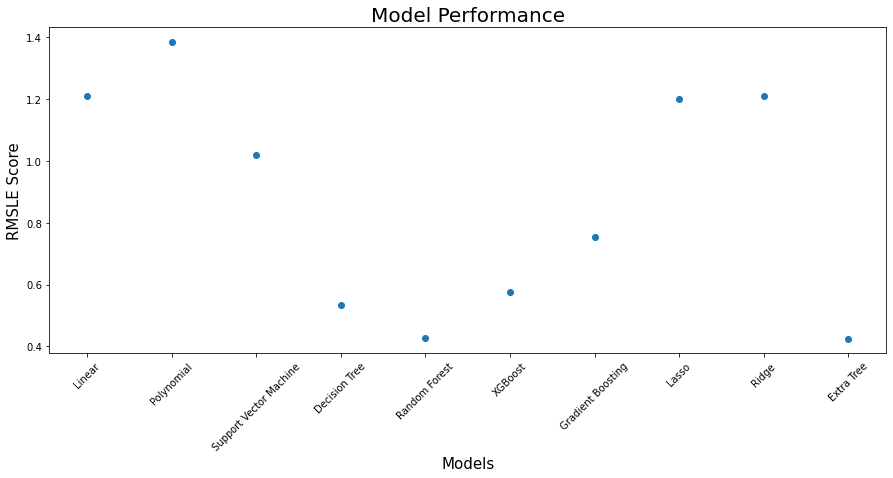

In [9]:
plt.figure(figsize=(15,6))
plt.title("Model Performance", fontsize=20)
plt.xlabel("Models", fontsize=15)
plt.ylabel("RMSLE Score", fontsize=15)
plt.scatter(perf_df['Regression Models'], perf_df['RMSLE score'])
plt.xticks(rotation=45)
plt.show()

### We can see that Tree based Ensemble algorithms like Random Forest and Extra Trees are performing quite well as compared to other models. Moving forward, <u>I will be working with Random Forest algorithm.</u>

### Model performance can further be improved using most appropriate model hyperparameters which can be found using optimization technique like <u>Hyperparameter Tuning</u>. 

### I will be using <u>Randomized Search CV</u> method with a CV of 3 for 100 combinations to find optimal set of hyperparameters.

## Approach #1

### Randomized Search CV

In [10]:
# Parameters to search on
param_dist = {
    "n_estimators" : [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    "max_features" : ["auto", "sqrt", "log2"],
    "max_depth" : [int(x) for x in np.linspace(start=10, stop=100, num=10)],
    "min_samples_split" : [1,2,3,4,5,6,7,8,9,10],
    "min_samples_leaf" : [1,2,3,4,5],
    "bootstrap" : [True, False]
}
pprint(param_dist)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [11]:
# Search across 100 different combinations of parameters
rf_model = RandomForestRegressor()
# Create the RandomizedSearchCV instance
rscv = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100, n_jobs=-1,
                         cv=3, verbose=2, random_state=42)
# Fit the random search model
rscv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 57.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [12]:
# Best Parameters for our model
print("Best Parameters :\n")
rscv.best_params_

Best Parameters :



{'n_estimators': 1200,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

### GridSearch CV

In [13]:
# Parameters to search on
param_grid = {
    "n_estimators" : [1180, 1190, 1200, 1210, 1220],
    "max_features" : ["auto"],
    "max_depth" : [78,79,80,81,82]
}
pprint(param_grid)

{'max_depth': [78, 79, 80, 81, 82],
 'max_features': ['auto'],
 'n_estimators': [1180, 1190, 1200, 1210, 1220]}


In [14]:
# Search across all possible combinations of parameters
rf_model = RandomForestRegressor()

# Create the RandomizedSearchCV instance
gscv = GridSearchCV(estimator=rf_model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)

# Fit the random search model
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 65.0min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [78, 79, 80, 81, 82],
                         'max_features': ['auto'],
                         'n_estimators': [1180, 1190, 1200, 1210, 1220]},
             verbose=1)

In [15]:
# Getting the best parameters
gscv.best_params_

{'max_depth': 79, 'max_features': 'auto', 'n_estimators': 1210}

### Let's train our Random Forest Model again with above best parameters and see if there is any improvement.

In [16]:
# We will fit this model for 10 iterations and take the mean RMSLE.
# We will also store models and chose the model with lowest RMSLE score for prediction.
rmsle_scores = []
models = []
for i in range(10):
    # Fitting the model
    model_app_1 = RandomForestRegressor(n_estimators=1210,
                                     min_samples_split=6,
                                     min_samples_leaf=1,
                                     max_features='auto',
                                     max_depth=79,
                                     bootstrap=True
                                    )
    model_app_1.fit(X_train, y_train)

    # predictions
    y_preds_app1 = model_app_1.predict(X_val)

    # Compute the RMSLE score
    msle = mean_squared_log_error(y_preds_app1, y_val)
    rmsle = np.sqrt(msle)
    rmsle_scores.append(rmsle)
    models.append(model_app_1)

print("RMSLE score for Random Forest after Parameter Tuning : {:.5f}".format(np.mean(rmsle_scores)))

RMSLE score for Random Forest after Parameter Tuning : 0.42531


There is an improvement of ~0.0023 in the RMSLE score. This is not much but atleast it is an improvement which is a good sign :)

# Let's check how closely our model has predicted the values to actual ones 

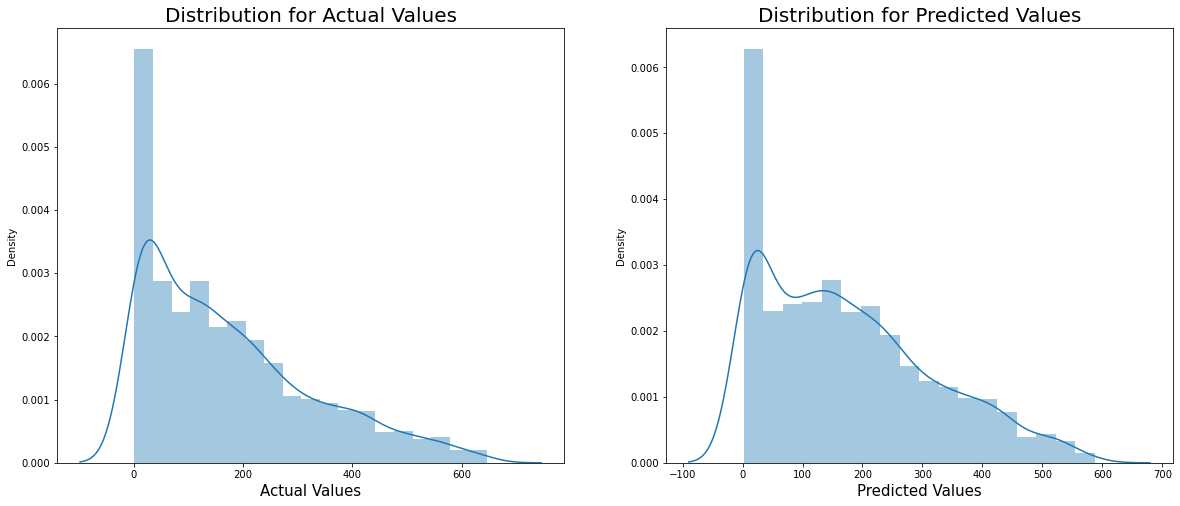

In [17]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title("Distribution for Actual Values", fontsize=20)
sns.distplot(y_val, ax=ax[0])
ax[0].set_xlabel("Actual Values", fontsize=15)

ax[1].set_title("Distribution for Predicted Values", fontsize=20)
sns.distplot(y_preds_app1, ax=ax[1])
ax[1].set_xlabel("Predicted Values", fontsize=15)

plt.show()

### We can confirm visually that our predictions are really close to the actual values and our model performed really well.

In [18]:
# Select best model with least RMSLE score
best_score_idx = np.argmin(rmsle_scores)
best_model_app_1 = models[best_score_idx]

# Prediction + Submission

In [20]:
# predict on test data
y_preds = best_model_app_1.predict(test_df)

# convert to dataframe
y_preds_df = pd.DataFrame({'count' : y_preds})

# Extract datetime column values in a dataframe
datetime_df = pd.DataFrame(pd.read_csv('test.csv')['datetime'])

# Combine the 2 dataframes
subm = pd.concat([datetime_df, y_preds_df], axis=1)
subm.head()

# Convert to csv file
subm.to_csv('sampleSubmission.csv', index=False)

# Save approach #1 model

In [21]:
pickle.dump(best_model_app_1, open('modal_approach_1.pkl', 'wb'))

## Approach #2

### In this section, we will try to look at the feature importances and select only those features which have a good contribution towards the model performance. So let's look into it and eliminate the irrelevant ones. Right feature selection will:
* Improve model accuracy.
* Decrease the error value.
* Increase training speed.

**To perform Feature Selection, we will use the following techniques:**
1. Feature Importance.
2. Recursive Feature Elimination (RFE).

In [22]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

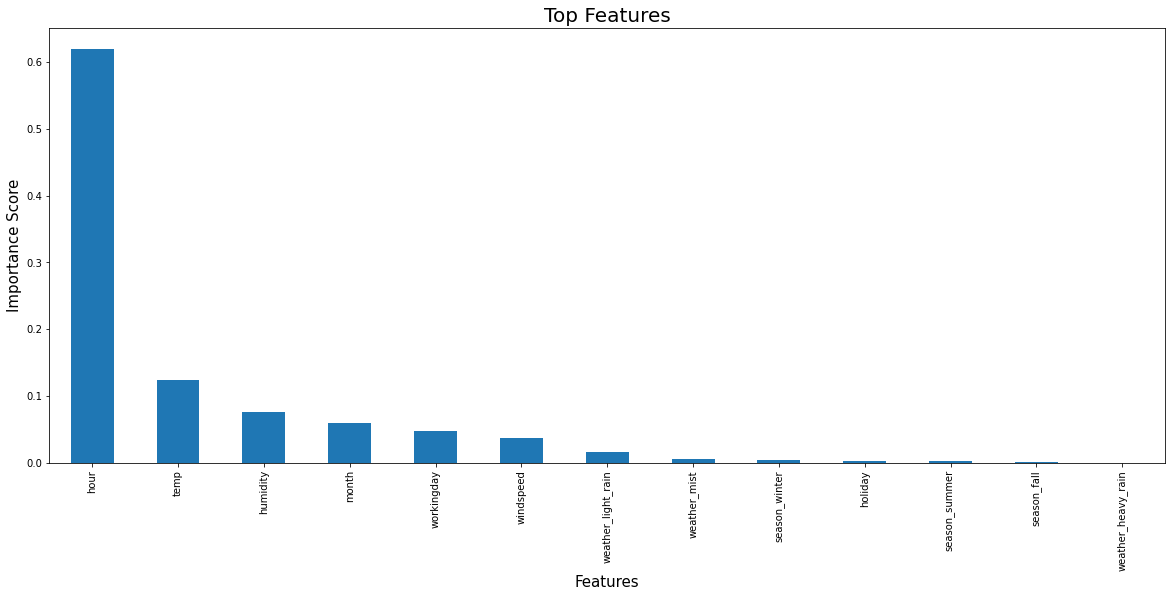

In [23]:
'''
FEATURE IMPORTANCE METHOD :-

Here we will make use of feature_importances_ attribute of Random Forest to look at 
which features did our model considered the most important.
'''
plt.figure(figsize=(20, 8))
plt.title("Top Features", fontsize=20)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Importance Score", fontsize=15)
feat_importances = pd.Series(model.feature_importances_, index= X_train.columns)
feat_importances.nlargest(13).plot(kind='bar')

The Feature importance attribute gives us which feature is how much important in terms of score but it <u>doesn't tell us about the optimal number of features</u> to select. We selected the number "13" at random.

To get the optimal number of features to be selected, we use Recursive Feature Elimination (RFE). <u>RFE is compute intensive but is a very robust method to select features with great accuracy</u> as the process is iterative. 

In [24]:
'''
RECURSIVE FEATURE ELIMINATION (RFE)

Here, we make use of for loop to iterate over different number of features and store model scores with that 
many number of features in each iteration. Number of feature corresponding to best model score will be chosen
as the selected features for final training.
'''
start = time.time()
nof = 0
high_score = 0
scores = []
nb_features = X_train.shape[1]
for i in range(nb_features):
    print("Iteration :", i+1)
    model = RandomForestRegressor()
    rfe = RFE(estimator=model, n_features_to_select=i+1)
    X_train_rfe = rfe.fit_transform(X_train, y_train) # this returns selected features in train data 
    X_val_rfe = rfe.transform(X_val) # this returns selected features in validation data
    model.fit(X_train_rfe, y_train)
    score = model.score(X_val_rfe, y_val)
    scores.append(score)
    if score > high_score:
        high_score = score
        nof = i+1
        print("High Score :", high_score)
        print("Number of features :", nof)

print("Optimal number of features :", nof)
print("Total execution time for RFE : " +  str(round((time.time() - start)/60, 4)) + " minutes.")

Iteration : 1
High Score : 0.47857389636143355
Number of features : 1
Iteration : 2
High Score : 0.5564923210781147
Number of features : 2
Iteration : 3
Iteration : 4
High Score : 0.622810349054665
Number of features : 4
Iteration : 5
High Score : 0.8332248850937329
Number of features : 5
Iteration : 6
High Score : 0.8384003522599662
Number of features : 6
Iteration : 7
High Score : 0.8434366154508933
Number of features : 7
Iteration : 8
High Score : 0.8451224162293905
Number of features : 8
Iteration : 9
Iteration : 10
High Score : 0.8497776570016321
Number of features : 10
Iteration : 11
High Score : 0.8499283505151458
Number of features : 11
Iteration : 12
High Score : 0.8511100651339913
Number of features : 12
Iteration : 13
Optimal number of features : 12
Total execution time for RFE : 11.6549 minutes.


### We got optimal number of features as 11 with a model accuracy of ~85%.
* No. of features retained = 11
* No of features rejected = 2

### Now let's look at labels of these 11 features, extract them and make a new dataframe of reduced features for further use.

In [25]:
model = RandomForestRegressor()
rfe = RFE(estimator=model, n_features_to_select=11)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_val)
model.fit(X_train_rfe, y_train)
temp = pd.Series(rfe.support_)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11], dtype='int64')


In [26]:
selected_features_rfe = list(selected_features_rfe)
selected_features = []
for idx in selected_features_rfe:
    selected_features.append(X_train.columns[idx])
print("Selected Features : \n", selected_features)

# Extract reduced feature dataframe from Train and Validation set
X_train_reduced = X_train[selected_features]
X_val_reduced = X_val[selected_features]

Selected Features : 
 ['hour', 'month', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'season_summer', 'season_winter', 'weather_mist', 'weather_light_rain']


# Train model with reduced features and best parameters

In [27]:
# Train model for 10 iterations and take mean RMSLE score.
# We will also store models and take the best model for prediction.
score_list = []
models = []
for i in range(10):
    # Fit the model
    model_app_2 = RandomForestRegressor(n_estimators=1210,
                                     min_samples_split=6,
                                     min_samples_leaf=1,
                                     max_features='auto',
                                     max_depth=79,
                                     bootstrap=True
                                    )
    model_app_2.fit(X_train_reduced, y_train)

    # prediction
    y_preds_app2 = model_app_2.predict(X_val_reduced)

    # Compute RMSLE score
    msle = mean_squared_log_error(y_preds_app2, y_val)
    rmsle = np.sqrt(msle)
    score_list.append(rmsle)
    models.append(model_app_2)

print("RMSLE Score after Feature Selection : {:.5f}".format(np.mean(score_list)))

RMSLE Score after Feature Selection : 0.42513


### There is a very little improvement after selecting important features. (~0.0002)

# Let's now check how close our predictions are to the actual values 

In [28]:
# Select best model with least RMSLE score
best_score_idx = np.argmin(score_list)
best_model_app_2 = models[best_score_idx]

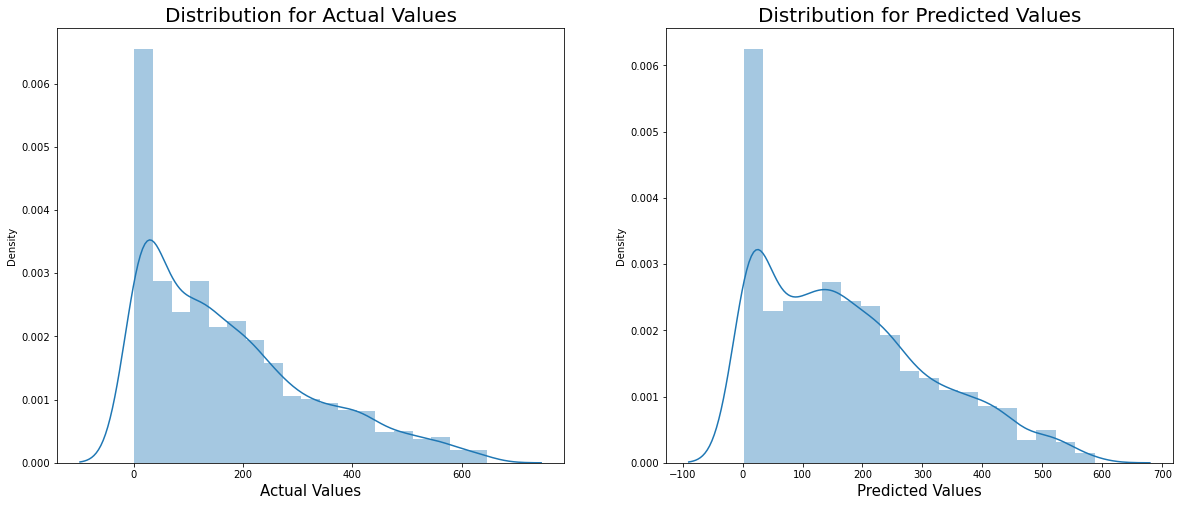

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title("Distribution for Actual Values", fontsize=20)
sns.distplot(y_val, ax=ax[0])
ax[0].set_xlabel("Actual Values", fontsize=15)

ax[1].set_title("Distribution for Predicted Values", fontsize=20)
sns.distplot(y_preds_app2, ax=ax[1])
ax[1].set_xlabel("Predicted Values", fontsize=15)

plt.show()

### We can confirm visually that our predictions are really close to the actual values and our model performed really well.

# Prediction + Submission

In [30]:
# predict on test data
X_test = test_df[selected_features]
y_preds = best_model_app_2.predict(X_test)

# convert to dataframe
y_preds_df = pd.DataFrame({'count' : y_preds})

# Extract datetime column values in a dataframe
datetime_df = pd.DataFrame(pd.read_csv('test.csv')['datetime'])

# Combine the 2 dataframes
subm = pd.concat([datetime_df, y_preds_df], axis=1)
subm.head()

# Convert to csv file
subm.to_csv('sampleSubmission.csv', index=False)

# Saving model of approach #2

In [31]:
with open('model_approach_2.pkl', 'wb') as file:
    pickle.dump(best_model_app_2, file)